# Customer Segmentation using K-Means Algorithm for Seasonal Profiles

The individual files should contain 3 months data of energy consumption in 15 minute interval

In [2]:
import polars as pl
import glob
import re
from pathlib import Path
import os
from datetime import datetime

import polars as pl
import re
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from datetime import date, datetime
from datetime import timedelta
from tslearn.clustering import TimeSeriesKMeans 
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

logging.getLogger('matplotlib.font_manager').disabled = True

from validation import validation

## Select the season for clustering

In [ ]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer-_Segmentation_CKW/DATA/SM_DATA_cleaned")

timestamp_range = pl.datetime_range(datetime(2024, 6, 1), datetime(2024, 12, 31), "1d", eager=True).cast(pl.Date)

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

def day_avg_preprocess_season(df, season):
    # Parse the timestamp column
    
    if season == "spring":
        timestamp_range = pl.datetime_range(datetime(2024,3,1), datetime(2024,5,31), "1d",eager=True)
    elif season == "summer":
        timestamp_range = pl.datetime_range(datetime(2024,6,1), datetime(2024,8,31), "1d",eager=True)
    elif season == "autumn":
        timestamp_range = pl.datetime_range(datetime(2024,8,31,23), datetime(2024,11,30), "1d",eager=True)
    else:
        timestamp_range = pl.concat([pl.datetime_range(datetime(2024,1,1), datetime(2024,2,28), "1d",eager=True), 
                                     pl.datetime_range(datetime(2024,12,1), datetime(2024,12,31), "1d",eager=True)])
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )

    timestamp_range = timestamp_range.cast(pl.Date)

    # In your function, ensure the datetime column is cast to Date for comparison
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.date().alias("date_only")
    )

    df = df.filter(
        pl.col("date_only").is_in(timestamp_range.implode())
    )
    
    # Sort by datetime
    df = df.sort("zeitpunkt_dt")
    
    # Filter only Saturdays and Sundays
    #df = df.filter(pl.col("zeitpunkt_dt").dt.weekday().is_in([5, 6]))
    
    # Extract time_of_day as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )
    
    # Group by time_of_day and compute mean
    day_avg = (
        df.group_by("time_of_day")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("time_of_day")
    )
    
    return day_avg

def normalize(df):
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )
    
    return df

base_output_folder = Path("/Users/jansigrist/Documents/SP/Customer-_Segmentation_CKW/DATA/SM_DATA_seasonal_normalized")

for season in ["spring", "summer", "autumn", "winter"]:
    # Create a folder for the current season
    season_folder = base_output_folder / f"SM_DATA_seasonal_normalized_{season}"
    season_folder.mkdir(parents=True, exist_ok=True)
    
    for file_path in file_paths:
        df = pl.read_csv(file_path)
        day_avg = day_avg_preprocess_season(df, season)
        day_avg = normalize(day_avg)
        
        filename = os.path.basename(file_path)  # Extract original filename
        output_file = season_folder / filename  # Write to season-specific folder
        
        day_avg.write_csv(output_file)

In [4]:
season = "winter"

pattern = f"DATA/SM_DATA_seasonal_normalized/SM_DATA_seasonal_normalized_{season}/*CH*.csv"
file_paths = glob.glob(pattern)

print(f"Number of files for season {season}: {len(file_paths)}")

Number of files for season winter: 1464


Shape of the 3D array: (1464, 96, 1)


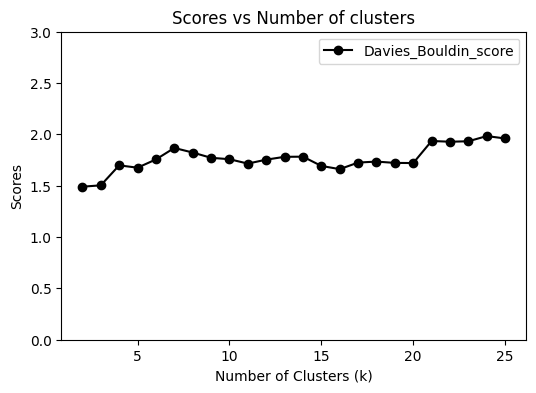

In [5]:
n_timestamps = 96

data_list = []

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)

data_3d = np.concatenate(data_list, axis=0)
print(f"Shape of the 3D array: {data_3d.shape}")

train_data = data_3d

validation(train_data)

In [48]:
n_clusters = 5  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

3.072 --> 2.233 --> 2.191 --> 2.179 --> 2.168 --> 2.160 --> 2.156 --> 2.153 --> 2.151 --> 2.149 --> 2.149 --> 2.148 --> 2.148 --> 2.148 --> 2.147 --> 2.146 --> 2.145 --> 2.145 --> 2.145 --> 2.145 --> 2.145 --> 


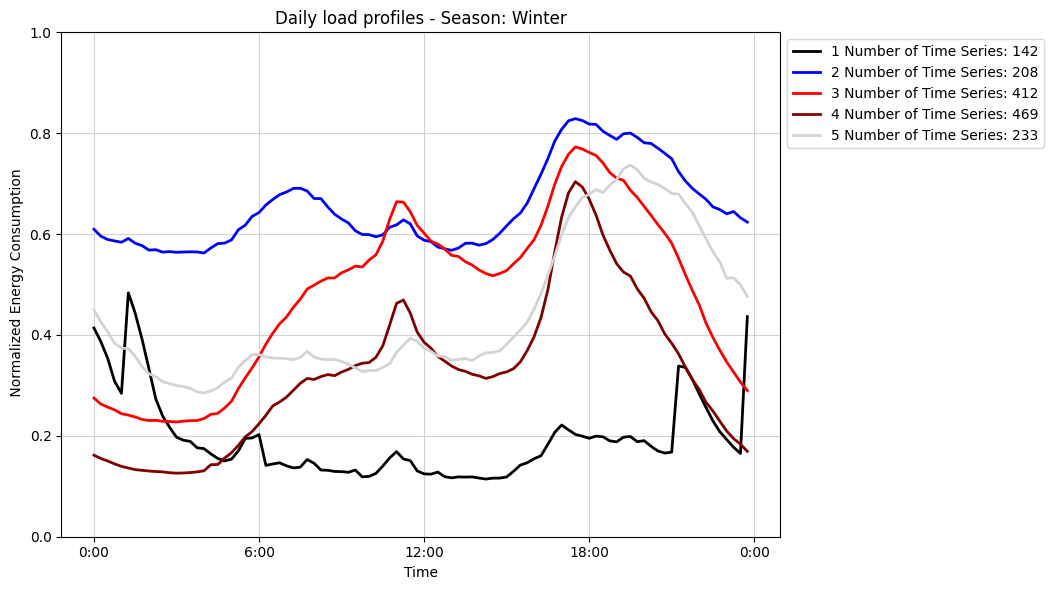

In [49]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['black','blue','red','maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','magenta','pink','violet']

def plot_clusters_season():
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'{cluster_no} Number of Time Series: {len(cluster_indices)}',
                linewidth =2, color=colors[cluster_idx] )
    plt.title(f'Daily load profiles - Season: {season.capitalize()}')
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    #plt.xticks(range(1,108,12),labels=labels)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend()
    #plt.margins(0)
    plt.grid(True, color = 'lightgray')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig("/Users/jansigrist/Documents/SP/Customer-_Segmentation_CKW/Results/Plots_seasonal/" \
    "seasonal_clusters_" + season + ".png")
    plt.show()
    

plot_clusters_season()